# Examples with SGP4 library
Source: https://pypi.org/project/sgp4/ <br/>
Source: https://docs.astropy.org/en/stable/coordinates/satellites.html

Installation: `pip install sgp4`

In [13]:
from sgp4.api import accelerated
print(accelerated)

True


In [2]:
from sgp4.api import Satrec

s = '1 25544U 98067A   19343.69339541  .00001764  00000-0  38792-4 0  9991'
t = '2 25544  51.6439 211.2001 0007417  17.6667  85.6398 15.50103472202482'
satellite = Satrec.twoline2rv(s, t)

In [3]:
from sys import stdout
from sgp4.conveniences import dump_satrec

stdout.writelines(dump_satrec(satellite))


# -------- Identification --------
satnum_str = '25544'
satnum = 25544
classification = 'U'
ephtype = 0
elnum = 999
revnum = 20248

# -------- Orbital Elements --------
epochyr = 19
epochdays = 343.69339541
ndot = 5.3450708342326346e-11
nddot = 0.0
bstar = 3.8792e-05
inclo = 0.9013560935706996
nodeo = 3.686137125541276
ecco = 0.0007417
argpo = 0.3083420829620822
mo = 1.4946964807494398
no_kozai = 0.06763602333248933
no = 0.06763602333248933
jdsatepoch = 2458826.5
jdsatepochF = 0.69339541

# -------- Computed Orbit Properties --------
a = 1.0653687733324535
altp = 0.06457858931327287
alta = 0.06615895735163435
argpdot = 4.468651165400969e-05
gsto = 5.720451405425919
mdot = 0.06763603112092395
nodedot = -6.007625962184691e-05

# -------- Propagator Mode --------
operationmode = 'i'
method = 'n'

# -------- Result of Most Recent Propagation --------
t = 0.0
error = 0

# -------- Mean Elements From Most Recent Propagation --------
am = 1.0653687733324535
em = 0.0007417
im = 0.901356093570

In [4]:
satellite

In [5]:
# Convert datetime to JD
from astropy.time import Time
t = Time('2018-12-09T00:00:00.123456789', format='isot', scale='utc')

e, teme_p, teme_v = satellite.sgp4(t.jd1, t.jd2) # non-zero error code if the satellite position could not be computed for the given date.
e

0

In [6]:
# Analyse error codes
from sgp4.api import SGP4_ERRORS
SGP4_ERRORS

{1: 'mean eccentricity is outside the range 0.0 to 1.0',
 2: 'nm is less than zero',
 3: 'perturbed eccentricity is outside the range 0.0 to 1.0',
 4: 'semilatus rectum is less than zero',
 5: '(error 5 no longer in use; it meant the satellite was underground)',
 6: 'mrt is less than 1.0 which indicates the satellite has decayed'}

In [7]:
from astropy.coordinates import TEME, ITRS, CartesianDifferential, CartesianRepresentation
from astropy import units as u
from astropy.time import Time
from sgp4.api import Satrec

# Manually create TLE
s = '1 25544U 98067A   19343.69339541  .00001764  00000-0  38792-4 0  9991'
t = '2 25544  51.6439 211.2001 0007417  17.6667  85.6398 15.50103472202482'
satellite = Satrec.twoline2rv(s, t)

# Manually provide JD
t = Time(2458827.362605, format='jd')

# Calculate position and velocity with sgp4
error_code, teme_p, teme_v = satellite.sgp4(t.jd1, t.jd2) # non-zero error code if the satellite position could not be computed for the given date.

# teme_p measures the satellite position in kilometers from the center of the earth in the
# idiosyncratic True Equator Mean Equinox coordinate frame used by SGP4.
print(f"Position [True Equator Mean Equinox]: {teme_p} (km)")

# teme_v velocity is the rate at which the position is changing, expressed in kilometers
# per second.
print(f"Velocity [True Equator Mean Equinox]: {teme_v} (km/s)")

# Convert from TEME to Other Coordinate Systems
teme_p = CartesianRepresentation(teme_p*u.km)
teme_v = CartesianDifferential(teme_v*u.km/u.s)

# Note how we are careful to set the observed time of the TEME
# frame to the time at which we calculated satellite position.
teme = TEME(teme_p.with_differentials(teme_v), obstime=t)

Position [True Equator Mean Equinox]: (-6102.443276428913, -986.3320160861297, -2820.3130707199225) (km)
Velocity [True Equator Mean Equinox]: (-1.4552527284474308, -5.527413835655969, 5.101042029427083) (km/s)


In [8]:
teme

<TEME Coordinate (obstime=2458827.362605): (x, y, z) in km
    (-6102.44327643, -986.33201609, -2820.31307072)
 (v_x, v_y, v_z) in km / s
    (-1.45525273, -5.52741384, 5.10104203)>

In [9]:
# to find the overhead latitude, longitude, and height of the satellite:
itrs_geo = teme.transform_to(ITRS(obstime=t))
itrs_geo = teme.transform_to(ITRS(obstime=t))
location = itrs_geo.earth_location
location.geodetic

GeodeticLocation(lon=<Longitude 160.34199791 deg>, lat=<Latitude -24.66093788 deg>, height=<Quantity 420.1792759 km>)

In [10]:
# to find the altitude and azimuth of the satellite from a particular location
from astropy.coordinates import EarthLocation, AltAz
siding_spring = EarthLocation.of_address('4 Ormond Road, Ormond, Vic 3204, Australia')
topo_itrs_repr = itrs_geo.cartesian.without_differentials() - siding_spring.get_itrs(t).cartesian
itrs_topo = ITRS(topo_itrs_repr, obstime = t, location=siding_spring)
aa = itrs_topo.transform_to(AltAz(obstime=t, location=siding_spring))
print(aa.alt.deg, aa.az.deg)  

1.7844267538836551 49.01192169515282


In [11]:
satellite_1 = {
    'name': 'SAT-1',
    'alt': aa.alt.deg,
    'az': aa.az.deg
}

satellite_1

{'name': 'SAT-1', 'alt': 1.7844267538836551, 'az': 49.01192169515282}

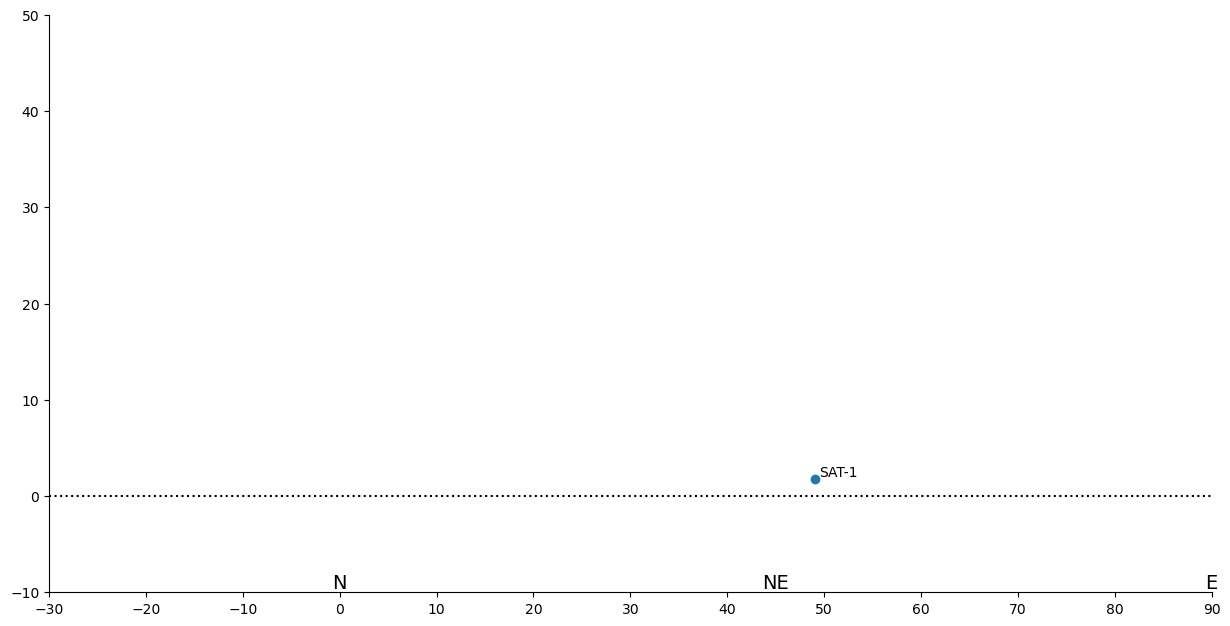

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Human Fielf of Vision
FOV_v = 60 # deg
FOV_h = 120 # deg

# Line of sight
los_az = 30 # deg away from North (positive = look East)
los_el = 20 # deg above horizon

# Calculate FOV boundaries
x_min = -FOV_h/2 + los_az
x_max = FOV_h/2 + los_az
y_min = -FOV_v/2 + los_el
y_max = FOV_v/2 + los_el

scale_factor = 8

# Create figure
fig, ax = plt.subplots(figsize=(FOV_h/scale_factor, FOV_v/scale_factor))
sns.despine()

# Display horizon
ax.hlines(0, x_min, x_max, colors='k', ls=':')

# Display satellites
x_pos = satellite_1['az']
y_pos = satellite_1['alt']
s_name = satellite_1['name']
ax.scatter(x=x_pos, y=y_pos)
ax.annotate(s_name, [x_pos, y_pos], [x_pos+.5, y_pos], ha='left', va='bottom', fontsize=10)

# Display compass
ax.annotate('N', [0,y_min], ha='center', va='bottom', fontsize=14)
ax.annotate('NE', [45,y_min], ha='center', va='bottom', fontsize=14)
ax.annotate('E', [90,y_min], ha='center', va='bottom', fontsize=14)
ax.annotate('SE', [135,y_min], ha='center', va='bottom', fontsize=14)
ax.annotate('S', [180,y_min], ha='center', va='bottom', fontsize=14)
ax.annotate('S', [-180,y_min], ha='center', va='bottom', fontsize=14)
ax.annotate('SW', [-135,y_min], ha='center', va='bottom', fontsize=14)
ax.annotate('W', [-90,y_min], ha='center', va='bottom', fontsize=14)
ax.annotate('NW', [-45,y_min], ha='center', va='bottom', fontsize=14)
ax.set_xticks(np.arange(-360,360,10))

# Set field of view limits
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)

plt.show()